# Observational Datasets

In [1]:
import os
import copy
from datetime import date

import xarray as xr
import pandas as pd
import numpy as np
import dask
import glob

from dask_jobqueue import PBSCluster
from dask.distributed import Client

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib
import matplotlib.pyplot as plt

## PBS Cluster Setup

In [2]:
# Setup PBSCluster
cluster = PBSCluster(
    cores=1,                                     # The number of cores you want
    memory='25GB',                               # Amount of memory
    processes=1,                                 # How many processes
    queue='casper',                              # The type of queue to utilize
    local_directory='/glade/work/afoster',       # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB',   # Specify resources
    project='P93300041',                         # Input your project ID here
    walltime='04:00:00',                         # Amount of wall time
    interface='ext',                             # Interface to use
)

/glade/work/afoster/conda-envs/ml_analysis/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/afoster/conda-envs/ml_analysis/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36921 instead
  warnings.warn(


In [3]:
cluster.scale(10)

/glade/work/afoster/conda-envs/ml_analysis/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


In [4]:
client = Client(cluster)

## Helper Functions

In [5]:
def month_wts(nyears):
    days_pm = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    return xr.DataArray(np.tile(days_pm, nyears), dims='time')

In [6]:
def adjust_lon(ds, lon_name):

    # Adjust lon values to make sure they are within (-180, 180)
    ds['_longitude_adjusted'] = xr.where(
        ds[lon_name] > 180,
        ds[lon_name] - 360,
        ds[lon_name])

    # reassign the new coords to as the main lon coords
    # and sort DataArray using new coordinate values
    ds = (
        ds
        .swap_dims({lon_name: '_longitude_adjusted'})
        .sel(**{'_longitude_adjusted': sorted(ds._longitude_adjusted)})
        .drop_vars(lon_name))

    ds = ds.rename({'_longitude_adjusted': lon_name})

    return ds

In [7]:
def get_annual_obs(ds, var, cf, mask):

    ds_updated = ds.sel(time=slice('2005-01-01', '2014-12-31'))

    nyears = len(np.unique(ds_updated['time.year']))

    mask_interp = mask.interp(lat=ds_updated['lat'], lon=ds_updated['lon'])

    # calculate annual values
    annual = cf*(ds_updated[var]*month_wts(nyears)).groupby('time.year').sum()

    annual = annual.where(mask_interp == 1.0)

    return annual

In [28]:
def CellAreas(lat, lon, lat_bnds=None, lon_bnds=None):
    """Given arrays of latitude and longitude, return cell areas in square meters.

    Parameters
    ----------
    lat : numpy.ndarray
        a 1D array of latitudes which represent cell centroids
    lon : numpy.ndarray
        a 1D array of longitudes which represent cell centroids

    Returns
    -------
    areas : numpy.ndarray
        a 2D array of cell areas in [m2]
    """
    earth_rad = 6.371e6

    if lat_bnds is not None and lon_bnds is not None:
        return earth_rad**2 * np.outer(
            (
                np.sin(lat_bnds[:, 1] * np.pi / 180.0)
                - np.sin(lat_bnds[:, 0] * np.pi / 180.0)
            ),
            (lon_bnds[:, 1] - lon_bnds[:, 0]) * np.pi / 180.0,
        )

    x = np.zeros(lon.size + 1)
    x[1:-1] = 0.5 * (lon[1:] + lon[:-1])
    x[0] = lon[0] - 0.5 * (lon[1] - lon[0])
    x[-1] = lon[-1] + 0.5 * (lon[-1] - lon[-2])
    if x.max() > 181:
        x -= 180
    x = x.clip(-180, 180)
    x *= np.pi / 180.0

    y = np.zeros(lat.size + 1)
    y[1:-1] = 0.5 * (lat[1:] + lat[:-1])
    y[0] = lat[0] - 0.5 * (lat[1] - lat[0])
    y[-1] = lat[-1] + 0.5 * (lat[-1] - lat[-2])
    y = y.clip(-90, 90)
    y *= np.pi / 180.0

    dx = earth_rad * (x[1:] - x[:-1])
    dy = earth_rad * (np.sin(y[1:]) - np.sin(y[:-1]))
    areas = np.outer(dx, dy).T

    return areas

## Observations

In [50]:
ds_sp = xr.open_dataset('/glade/campaign/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_cesm201R_1deg_GSWP3V1_phsoff_hist/lnd/proc/tseries/month_1/clm50_cesm201R_1deg_GSWP3V1_phsoff_hist.clm2.h0.ELAI.185001-201412.nc')
mask = adjust_lon(ds_sp.landmask, 'lon')

In [9]:
dir = '/glade/campaign/cesm/community/lmwg/diag/ILAMB/DATA'
outdir = '/glade/work/afoster/FATES_calibration/ILAMB_data'

### GPP

In [49]:
# FLUXCOM
fluxcom_file = os.path.join(dir, 'gpp', 'FLUXCOM', 'gpp.nc')
fluxcom = xr.open_dataset(fluxcom_file)
fluxcom = fluxcom.where(fluxcom.gpp < 500)
lons = fluxcom.lon.values
lats = np.array(sorted(fluxcom.lat.values))
areas = CellAreas(lats, lons)

fluxcom_gpp = get_annual_obs(fluxcom, 'gpp', 1/1000.00, mask).mean(dim='year')
fluxcom_gpp = fluxcom_gpp.to_dataset(name='gpp')

fluxcom_gpp['land_area'] = xr.DataArray(areas, coords={"lat": lats, "lon": lons})
fluxcom_gpp['land_area'].attrs['units'] = 'm2'
fluxcom_gpp['land_area'].attrs['long_name'] = 'land area'

fluxcom_gpp['gpp'].attrs['units'] = 'kgC m-2 yr-1'
fluxcom_gpp['gpp'].attrs['long_name'] = 'gross primary production'

fluxcom_gpp.attrs['Original'] = fluxcom_file
fluxcom_gpp.attrs['Date'] = str(date.today())
fluxcom_gpp.attrs['Author'] = 'afoster@ucar.edu'
fluxcom_gpp.to_netcdf(os.path.join(outdir, 'FLUXCOM_GPP.nc'))

PermissionError: [Errno 13] Permission denied: '/glade/work/afoster/FATES_calibration/ILAMB_data/FLUXCOM_GPP.nc'

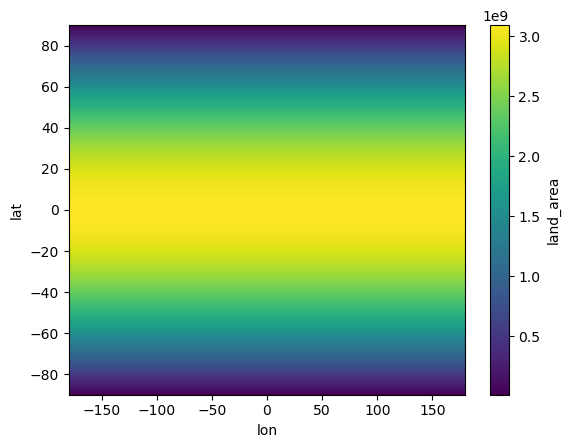

In [47]:
fluxcom_gpp.land_area.plot()

In [ ]:
# WECANN
wecann_file = os.path.join(dir, 'gpp', 'WECANN', 'gpp.nc')
wecann = xr.open_dataset(wecann_file)
wecann = wecann.where(wecann.gpp < 500)

wecann_gpp = get_annual_obs(wecann, 'gpp', 1/1000.0, mask).mean(dim='year')
wecann_gpp = wecann_gpp.to_dataset(name='gpp')

wecann_gpp['gpp'].attrs['units'] = 'kgC m-2 yr-1'
wecann_gpp['gpp'].attrs['long_name'] = 'gross primary production'

wecann_gpp.attrs['Original'] = wecann_file
wecann_gpp.attrs['Date'] = str(date.today())
wecann_gpp.attrs['Author'] = 'afoster@ucar.edu'
wecann_gpp.to_netcdf(os.path.join(outdir, 'WECANN_GPP.nc'))

In [ ]:
# GBAF
gbaf_file = os.path.join(dir, 'gpp', 'GBAF', 'gpp_0.5x0.5.nc')
gbaf = xr.open_dataset(gbaf_file)

gbaf_gpp = get_annual_obs(gbaf, 'gpp', 60.0*60.0*24.0, mask).mean(dim='year')
gbaf_gpp = gbaf_gpp.to_dataset(name='gpp')

gbaf_gpp['gpp'].attrs['units'] = 'kgC m-2 yr-1'
gbaf_gpp['gpp'].attrs['long_name'] = 'gross primary production'

gbaf_gpp.attrs['Original'] = gbaf_file
gbaf_gpp.attrs['Date'] = str(date.today())
gbaf_gpp.attrs['Author'] = 'afoster@ucar.edu'
gbaf_gpp.to_netcdf(os.path.join(outdir, 'GBAF_GPP.nc'))

### LAI

In [ ]:
# MODIS
modis_file = os.path.join(dir, 'lai', 'MODIS', 'lai_0.5x0.5.nc')
modis = xr.open_dataset(modis_file)

modis_lai = get_annual_obs(modis, 'lai', 1/365, mask).mean(dim='year')
modis_lai = modis_lai.to_dataset(name='lai')

modis_lai['lai'].attrs['units'] = 'm2 m-2'
modis_lai['lai'].attrs['long_name'] = 'leaf area index'

modis_lai.attrs['Original'] = modis_file
modis_lai.attrs['Date'] = str(date.today())
modis_lai.attrs['Author'] = 'afoster@ucar.edu'
modis_lai.to_netcdf(os.path.join(outdir, 'MODIS_LAI.nc'))

In [ ]:
# AVHRR
avhrr_file = os.path.join(dir, 'lai', 'AVHRR', 'lai_0.5x0.5.nc')
avhrr = xr.open_dataset(avhrr_file)

avhrr_lai = get_annual_obs(avhrr, 'lai', 1/365, mask).mean(dim='year')
avhrr_lai = avhrr_lai.to_dataset(name='lai')

avhrr_lai['lai'].attrs['units'] = 'm2 m-2'
avhrr_lai['lai'].attrs['long_name'] = 'leaf area index'

avhrr_lai.attrs['Original'] = avhrr_file
avhrr_lai.attrs['Date'] = str(date.today())
avhrr_lai.attrs['Author'] = 'afoster@ucar.edu'
avhrr_lai.to_netcdf(os.path.join(outdir, 'AVHRR_LAI.nc'))

In [ ]:
# AVH15C1
avh1_file = os.path.join(dir, 'lai', 'AVH15C1', 'lai.nc')
avh1 = xr.open_dataset(avh1_file)

avh1_lai = get_annual_obs(avh1, 'lai', 1/365, mask).mean(dim='year')
avh1_lai = avh1_lai.to_dataset(name='lai')

avh1_lai['lai'].attrs['units'] = 'm2 m-2'
avh1_lai['lai'].attrs['long_name'] = 'leaf area index'

avh1_lai.attrs['Original'] = avh1_file
avh1_lai.attrs['Date'] = str(date.today())
avh1_lai.attrs['Author'] = 'afoster@ucar.edu'
avh1_lai.to_netcdf(os.path.join(outdir, 'AVH15C1_LAI.nc'))

### ET

In [ ]:
# FLUXCOM
fluxcom_file = os.path.join(dir, 'hfls', 'FLUXCOM', 'le.nc')
fluxcom = xr.open_dataset(fluxcom_file)

fluxcom_et = get_annual_obs(fluxcom, 'le', 1/2.5e6*24*60*60, mask).mean(dim='year')
fluxcom_et = fluxcom_et.to_dataset(name='et')

fluxcom_et['et'].attrs['units'] = 'kgH2O m-2 yr-1'
fluxcom_et['et'].attrs['long_name'] = 'evapotranspiration flux'

fluxcom_et.attrs['Original'] = fluxcom_file
fluxcom_et.attrs['Date'] = str(date.today())
fluxcom_et.attrs['Author'] = 'afoster@ucar.edu'
fluxcom_et.to_netcdf(os.path.join(outdir, 'FLUXCOM_ET.nc'))

In [ ]:
# DOLCE
dolce_file = os.path.join(dir, 'evspsbl', 'DOLCE', 'DOLCE.nc')
dolce = xr.open_dataset(dolce_file)

dolce_et = get_annual_obs(dolce, 'hfls', 1/2.5e6*24*60*60, mask).mean(dim='year')
dolce_et = dolce_et.to_dataset(name='et')

dolce_et['et'].attrs['units'] = 'kgH2O m-2 yr-1'
dolce_et['et'].attrs['long_name'] = 'evapotranspiration flux'

dolce_et.attrs['Original'] = dolce_file
dolce_et.attrs['Date'] = str(date.today())
dolce_et.attrs['Author'] = 'afoster@ucar.edu'
dolce_et.to_netcdf(os.path.join(outdir, 'DOLCE_ET.nc'))

In [ ]:
# CLASS
class_file = os.path.join(dir, 'hfls', 'CLASS', 'hfls.nc')
class_dat = xr.open_dataset(class_file)

class_et = get_annual_obs(class_dat, 'hfls', 1/2.5e6*24*60*60, mask).mean(dim='year')
class_et = class_et.to_dataset(name='et')

class_et['et'].attrs['units'] = 'kgH2O m-2 yr-1'
class_et['et'].attrs['long_name'] = 'evapotranspiration flux'

class_et.attrs['Original'] = class_file
class_et.attrs['Date'] = str(date.today())
class_et.attrs['Author'] = 'afoster@ucar.edu'
class_et.to_netcdf(os.path.join(outdir, 'CLASS_ET.nc'))

In [ ]:
# WECANN
wecann_file = os.path.join(dir, 'hfls', 'WECANN', 'hfls.nc')
wecann = xr.open_dataset(wecann_file)
wecann = wecann.where(wecann.hfls < 500)

wecann_et = get_annual_obs(wecann, 'hfls', 1/2.5e6*24*60*60, mask).mean(dim='year')
wecann_et = wecann_et.to_dataset(name='et')

wecann_et['et'].attrs['units'] = 'kgH2O m-2 yr-1'
wecann_et['et'].attrs['long_name'] = 'evapotranspiration flux'

wecann_et.attrs['Original'] = wecann_file
wecann_et.attrs['Date'] = str(date.today())
wecann_et.attrs['Author'] = 'afoster@ucar.edu'
wecann_et.to_netcdf(os.path.join(outdir, 'WECANN_ET.nc'))

In [ ]:
# GBAF
gbaf_file = os.path.join(dir, 'le', 'GBAF', 'le_0.5x0.5.nc')
gbaf = xr.open_dataset(gbaf_file)

gbaf_et = get_annual_obs(gbaf, 'le', 1/2.5e6*24*60*60, mask).mean(dim='year')
gbaf_et = gbaf_et.to_dataset(name='et')

gbaf_et['et'].attrs['units'] = 'kgH2O m-2 yr-1'
gbaf_et['et'].attrs['long_name'] = 'evapotranspiration flux'

gbaf_et.attrs['Original'] = gbaf_file
gbaf_et.attrs['Date'] = str(date.today())
gbaf_et.attrs['Author'] = 'afoster@ucar.edu'
gbaf_et.to_netcdf(os.path.join(outdir, 'GBAF_ET.nc'))

### Runoff

In [ ]:
# LORA
lora_file = os.path.join(dir, 'mrro', 'LORA', 'LORA.nc')
lora = xr.open_dataset(lora_file)

lora_mrro = get_annual_obs(lora, 'mrro', 24*60*60/365, mask).mean(dim='year')
lora_mrro = lora_mrro.to_dataset(name='mrro')

lora_mrro['mrro'].attrs['units'] = 'mm day-1'
lora_mrro['mrro'].attrs['long_name'] = 'surface runoff'

lora_mrro.attrs['Original'] = lora_file
lora_mrro.attrs['Date'] = str(date.today())
lora_mrro.attrs['Author'] = 'afoster@ucar.edu'
lora_mrro.to_netcdf(os.path.join(outdir, 'LORA_MRRO.nc'))

In [ ]:
# CLASS
class_file = os.path.join(dir, 'mrro', 'CLASS', 'mrro.nc')
class_dat = xr.open_dataset(class_file)

class_mrro = get_annual_obs(class_dat, 'mrro', 24*60*60/365, mask).mean(dim='year')
class_mrro = class_mrro.to_dataset(name='mrro')

class_mrro['mrro'].attrs['units'] = 'mm day-1'
class_mrro['mrro'].attrs['long_name'] = 'surface runoff'

class_mrro.attrs['Original'] = class_file
class_mrro.attrs['Date'] = str(date.today())
class_mrro.attrs['Author'] = 'afoster@ucar.edu'
class_mrro.to_netcdf(os.path.join(outdir, 'CLASS_MRRO.nc'))

### SH

In [ ]:
# FLUXCOM
fluxcom_file = os.path.join(dir, 'hfss', 'FLUXCOM', 'sh.nc')
fluxcom = xr.open_dataset(fluxcom_file)

fluxcom_sh = get_annual_obs(fluxcom, 'sh', 1/365, mask).mean(dim='year')
fluxcom_sh = fluxcom_sh.to_dataset(name='sh')

fluxcom_sh['sh'].attrs['units'] = 'W m-2'
fluxcom_sh['sh'].attrs['long_name'] = 'sensible heat flux'

fluxcom_sh.attrs['Original'] = fluxcom_file
fluxcom_sh.attrs['Date'] = str(date.today())
fluxcom_sh.attrs['Author'] = 'afoster@ucar.edu'
fluxcom_sh.to_netcdf(os.path.join(outdir, 'FLUXCOM_SH.nc'))

In [ ]:
# CLASS
class_file = os.path.join(dir, 'hfss', 'CLASS', 'hfss.nc')
class_dat = xr.open_dataset(class_file)

class_sh = get_annual_obs(class_dat, 'hfss', 1/365, mask).mean(dim='year')
class_sh = class_sh.to_dataset(name='sh')

class_sh['sh'].attrs['units'] = 'W m-2'
class_sh['sh'].attrs['long_name'] = 'sensible heat flux'

class_sh.attrs['Original'] = class_file
class_sh.attrs['Date'] = str(date.today())
class_sh.attrs['Author'] = 'afoster@ucar.edu'

class_sh.to_netcdf(os.path.join(outdir, 'CLASS_SH.nc'))

In [ ]:
# WECANN
wecann_file = os.path.join(dir, 'hfss', 'WECANN', 'hfss.nc')
wecann = xr.open_dataset(wecann_file)
wecann = wecann.where(wecann.hfss < 500)

wecann_sh = get_annual_obs(wecann, 'hfss', 1/365, mask).mean(dim='year')
wecann_sh = wecann_sh.to_dataset(name='sh')

wecann_sh['sh'].attrs['units'] = 'W m-2'
wecann_sh['sh'].attrs['long_name'] = 'sensible heat flux'

wecann_sh.attrs['Original'] = wecann_file
wecann_sh.attrs['Date'] = str(date.today())
wecann_sh.attrs['Author'] = 'afoster@ucar.edu'
wecann_sh.to_netcdf(os.path.join(outdir, 'WECANN_SH.nc'))

In [ ]:
# GBAF
gbaf_file = os.path.join(dir, 'sh', 'GBAF', 'sh_0.5x0.5.nc')
gbaf = xr.open_dataset(gbaf_file)
gbaf = gbaf.where(gbaf.sh < 500)

gbaf_sh = get_annual_obs(gbaf, 'sh', 1/365, mask).mean(dim='year')
gbaf_sh = gbaf_sh.to_dataset(name='sh')

gbaf_sh['sh'].attrs['units'] = 'W m-2'
gbaf_sh['sh'].attrs['long_name'] = 'sensible heat flux'

gbaf_sh.attrs['Original'] = gbaf_file
gbaf_sh.attrs['Date'] = str(date.today())
gbaf_sh.attrs['Author'] = 'afoster@ucar.edu'
gbaf_sh.to_netcdf(os.path.join(outdir, 'GBAF_SH.nc'))

### Evaporative Fraction

In [ ]:
def evapfrac(sh, le, energy_threshold):
    sh = sh.where((sh > 0) & (le > 0) & ((le + sh) > energy_threshold))
    le = le.where((sh > 0) & (le > 0) & ((le + sh) > energy_threshold))
    ef = le/(le + sh)
    return ef

In [ ]:
# FLUXCOM
fluxcom_le_file = os.path.join(dir, 'hfls', 'FLUXCOM', 'le.nc')
fluxcom_sh_file = os.path.join(dir, 'hfss', 'FLUXCOM', 'sh.nc')
fluxcom = xr.open_dataset(fluxcom_le_file)
fluxcom_le = get_annual_obs(fluxcom, 'le', 1/365, mask).mean(dim='year')

fluxcom_ef = evapfrac(fluxcom_sh.sh, fluxcom_le, 20)
fluxcom_ef = fluxcom_ef.to_dataset(name='ef')

fluxcom_ef['ef'].attrs['units'] = '0-1'
fluxcom_ef['ef'].attrs['long_name'] = 'evaporative fraction (latent heat flux/(latent heat flux + sensible heat flux))'

fluxcom_ef.attrs['Original'] = fluxcom_le_file + ', ' + fluxcom_sh_file
fluxcom_ef.attrs['Date'] = str(date.today())
fluxcom_ef.attrs['Author'] = 'afoster@ucar.edu'
fluxcom_ef.to_netcdf(os.path.join(outdir, 'FLUXCOM_EF.nc'))

In [ ]:
# CLASS
class_le_file = os.path.join(dir, 'hfls', 'CLASS', 'hfls.nc')
class_sh_file = os.path.join(dir, 'hfss', 'CLASS', 'hfss.nc')
class_dat = xr.open_dataset(class_le_file)
class_le = get_annual_obs(class_dat, 'hfls', 1/365, mask).mean(dim='year')

class_ef = evapfrac(class_sh.sh, class_le, 20)
class_ef = class_ef.to_dataset(name='ef')

class_ef['ef'].attrs['units'] = '0-1'
class_ef['ef'].attrs['long_name'] = 'evaporative fraction (latent heat flux/(latent heat flux + sensible heat flux))'

class_ef.attrs['Original'] = class_le_file + ', ' + class_sh_file
class_ef.attrs['Date'] = str(date.today())
class_ef.attrs['Author'] = 'afoster@ucar.edu'
class_ef.to_netcdf(os.path.join(outdir, 'CLASS_EF.nc'))

In [ ]:
# WECANN
wecann_le_file = os.path.join(dir, 'hfls', 'WECANN', 'hfls.nc')
wecann_sh_file = os.path.join(dir, 'hfss', 'WECANN', 'hfss.nc')
wecann_dat = xr.open_dataset(wecann_le_file)
wecann_le = get_annual_obs(wecann_dat, 'hfls', 1/365, mask).mean(dim='year')

wecann_ef = evapfrac(wecann_sh.sh, wecann_le, 20)
wecann_ef = wecann_ef.to_dataset(name='ef')

wecann_ef['ef'].attrs['units'] = '0-1'
wecann_ef['ef'].attrs['long_name'] = 'evaporative fraction (latent heat flux/(latent heat flux + sensible heat flux))'

wecann_ef.attrs['Original'] = wecann_le_file + ', ' + wecann_sh_file
wecann_ef.attrs['Date'] = str(date.today())
wecann_ef.attrs['Author'] = 'afoster@ucar.edu'
wecann_ef.to_netcdf(os.path.join(outdir, 'WECANN_EF.nc'))

In [ ]:
# GBAF
gbaf_sh_file = os.path.join(dir, 'sh', 'GBAF', 'sh_0.5x0.5.nc')
gbaf_le_file = os.path.join(dir, 'le', 'GBAF', 'le_0.5x0.5.nc')
gbaf = xr.open_dataset(gbaf_le_file)
gbaf_le = get_annual_obs(gbaf, 'le', 1/365, mask).mean(dim='year')

gbaf_ef = evapfrac(gbaf_sh.sh, gbaf_le, 20)
gbaf_ef = gbaf_ef.to_dataset(name='ef')

gbaf_ef['ef'].attrs['units'] = '0-1'
gbaf_ef['ef'].attrs['long_name'] = 'evaporative fraction (latent heat flux/(latent heat flux + sensible heat flux))'

gbaf_ef.attrs['Original'] = gbaf_le_file + ', ' + gbaf_sh_file
gbaf_ef.attrs['Date'] = str(date.today())
gbaf_ef.attrs['Author'] = 'afoster@ucar.edu'
gbaf_ef.to_netcdf(os.path.join(outdir, 'GBAF_EF.nc'))

### Surface Soil Moisture

In [ ]:
# WangMao
wangmao_file = os.path.join(dir, 'mrsos', 'WangMao', 'mrsos_olc.nc')
wangmao = xr.open_dataset(wangmao_file)
wangmao = wangmao.where(wangmao.mrsos < 500)

wangmao_sw = get_annual_obs(wangmao, 'mrsos', 1/365, mask).mean(dim='year')
wangmao_sw = wangmao_sw.to_dataset(name='sw')

wangmao_sw['sw'].attrs['units'] = 'kg m-2'
wangmao_sw['sw'].attrs['long_name'] = 'surface soil moisture'

wangmao_sw.attrs['Original'] = wangmao_file
wangmao_sw.attrs['Date'] = str(date.today())
wangmao_sw.attrs['Author'] = 'afoster@ucar.edu'
wangmao_sw.to_netcdf(os.path.join(outdir, 'WangMao_SW.nc'))

### Albedo

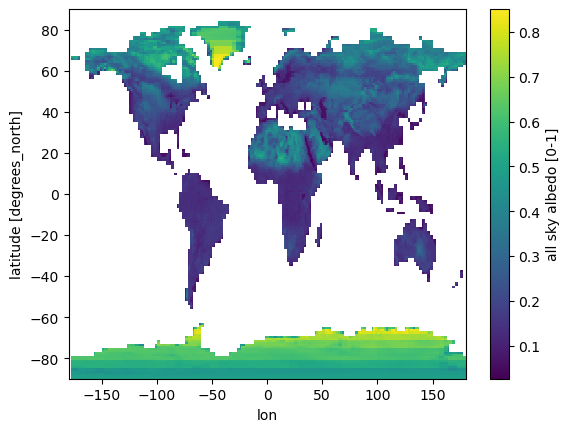

In [37]:
# CERESed4.2
ceres_file = os.path.join(dir, 'albedo', 'CERESed4.2', 'albedo.nc')
ceres_albedo = get_annual_obs(adjust_lon(ceres, 'lon'), 'albedo', 1/365, mask).mean(dim='year')
ceres_albedo = ceres_albedo.to_dataset(name='albedo')

ceres_albedo['albedo'].attrs['units'] = '0-1'
ceres_albedo['albedo'].attrs['long_name'] = 'all sky albedo'

ceres_albedo.attrs['Original'] = ceres_file
ceres_albedo.attrs['Date'] = str(date.today())
ceres_albedo.attrs['Author'] = 'afoster@ucar.edu'
ceres_albedo.to_netcdf(os.path.join(outdir, 'CERES_albedo.nc'))

In [ ]:
# GEWEX.SRB
gewex_file = os.path.join(dir, 'albedo', 'GEWEX.SRB', 'albedo_0.5x0.5.nc')
gewex = xr.open_dataset(gewex_file)
gewex = gewex.where(gewex.albedo <= 1.0)
gewex = gewex.where(gewex.albedo >= 0.0)

gewex_albedo = get_annual_obs(gewex, 'albedo', 1/365, mask).mean(dim='year')
gewex_albedo = gewex_albedo.to_dataset(name='albedo')

gewex_albedo['albedo'].attrs['units'] = '0-1'
gewex_albedo['albedo'].attrs['long_name'] = 'all sky albedo'

gewex_albedo.attrs['Original'] = gewex_file
gewex_albedo.attrs['Date'] = str(date.today())
gewex_albedo.attrs['Author'] = 'afoster@ucar.edu'
gewex_albedo.to_netcdf(os.path.join(outdir, 'GEWEX_albedo.nc'))

### Surface Upward SW Radiation

In [ ]:
# CERESed4.1
ceres_file = os.path.join(dir, 'rsus', 'CERESed4.1', 'rsus.nc')
ceres = xr.open_dataset(ceres_file)

ceres_fsr = get_annual_obs(ceres, 'rsus', 1/365, mask).mean(dim='year')
ceres_fsr = ceres_fsr.to_dataset(name='fsr')

ceres_fsr['fsr'].attrs['units'] = 'W m-2'
ceres_fsr['fsr'].attrs['long_name'] = 'surface upward shortwave radiation flux'

ceres_fsr.attrs['Original'] = ceres_file
ceres_fsr.attrs['Date'] = str(date.today())
ceres_fsr.attrs['Author'] = 'afoster@ucar.edu'
ceres_fsr.to_netcdf(os.path.join(outdir, 'CERES_FSR.nc'))

In [ ]:
# GEWEX.SRB
gewex_file = os.path.join(dir, 'rsus', 'GEWEX.SRB', 'rsus_0.5x0.5.nc')
gewex = xr.open_dataset(gewex_file)

gewex_fsr = get_annual_obs(gewex, 'rsus', 1/365, mask).mean(dim='year')
gewex_fsr = gewex_fsr.to_dataset(name='fsr')

gewex_fsr['fsr'].attrs['units'] = 'W m-2'
gewex_fsr['fsr'].attrs['long_name'] = 'surface upward shortwave radiation flux'

gewex_fsr.attrs['Original'] = gewex_file
gewex_fsr.attrs['Date'] = str(date.today())
gewex_fsr.attrs['Author'] = 'afoster@ucar.edu'
gewex_fsr.to_netcdf(os.path.join(outdir, 'GEWEX_FSR.nc'))

### Surface Net SW Radiation

In [ ]:
# CERESed4.1
ceres_file = os.path.join(dir, 'rsns', 'CERESed4.1', 'rsns.nc')
ceres = xr.open_dataset(ceres_file)

ceres_fsa = get_annual_obs(ceres, 'rsns', 1/365, mask).mean(dim='year')
ceres_fsa = ceres_fsa.to_dataset(name='fsa')

ceres_fsa['fsa'].attrs['units'] = 'W m-2'
ceres_fsa['fsa'].attrs['long_name'] = 'surface net shortwave radiation flux'

ceres_fsa.attrs['Original'] = ceres_file
ceres_fsa.attrs['Date'] = str(date.today())
ceres_fsa.attrs['Author'] = 'afoster@ucar.edu'
ceres_fsa.to_netcdf(os.path.join(outdir, 'CERES_FSA.nc'))

In [ ]:
# GEWEX.SRB
gewex_file = os.path.join(dir, 'rsns', 'GEWEX.SRB', 'rsns_0.5x0.5.nc')
gewex = xr.open_dataset(gewex_file)

gewex_fsa = get_annual_obs(gewex, 'rsns', 1/365, mask).mean(dim='year')
gewex_fsa = gewex_fsa.to_dataset(name='fsa')

gewex_fsa['fsa'].attrs['units'] = 'W m-2'
gewex_fsa['fsa'].attrs['long_name'] = 'surface net shortwave radiation flux'

gewex_fsa.attrs['Original'] = gewex_file
gewex_fsa.attrs['Date'] = str(date.today())
gewex_fsa.attrs['Author'] = 'afoster@ucar.edu'
gewex_fsa.to_netcdf(os.path.join(outdir, 'GEWEX_FSA.nc'))

### Surface Upward LW Radiation

In [ ]:
# CERESed4.1
ceres_file = os.path.join(dir, 'rlus', 'CERESed4.1', 'rlus.nc')
ceres = xr.open_dataset(ceres_file)

ceres_fire = get_annual_obs(ceres, 'rlus', 1/365, mask).mean(dim='year')
ceres_fire = ceres_fire.to_dataset(name='fire')

ceres_fire['fire'].attrs['units'] = 'W m-2'
ceres_fire['fire'].attrs['long_name'] = 'surface upward longwave radiation flux'

ceres_fire.attrs['Original'] = ceres_file
ceres_fire.attrs['Date'] = str(date.today())
ceres_fire.attrs['Author'] = 'afoster@ucar.edu'
ceres_fire.to_netcdf(os.path.join(outdir, 'CERES_FIRE.nc'))

In [ ]:
# GEWEX.SRB
gewex_file = os.path.join(dir, 'rlus', 'GEWEX.SRB', 'rlus_0.5x0.5.nc')
gewex = xr.open_dataset(gewex_file)

gewex_fire = get_annual_obs(gewex, 'rlus', 1/365, mask).mean(dim='year')
gewex_fire = gewex_fire.to_dataset(name='fire')

gewex_fire['fire'].attrs['units'] = 'W m-2'
gewex_fire['fire'].attrs['long_name'] = 'surface upward longwave radiation flux'

gewex_fire.attrs['Original'] = gewex_file
gewex_fire.attrs['Date'] = str(date.today())
gewex_fire.attrs['Author'] = 'afoster@ucar.edu'
gewex_fire.to_netcdf(os.path.join(outdir, 'GEWEX_FIRE.nc'))

### Surface Net Longwave Radiation

In [ ]:
# CERESed4.1
ceres_file = os.path.join(dir, 'rlns', 'CERESed4.1', 'rlns.nc')
ceres = xr.open_dataset(ceres_file)

ceres_rlns = get_annual_obs(ceres, 'rlns', 1/365, mask).mean(dim='year')
ceres_rlns = ceres_rlns.to_dataset(name='rlns')

ceres_rlns['rlns'].attrs['units'] = 'W m-2'
ceres_rlns['rlns'].attrs['long_name'] = 'surface net longwave radiation flux'

ceres_rlns.attrs['Original'] = ceres_file
ceres_rlns.attrs['Date'] = str(date.today())
ceres_rlns.attrs['Author'] = 'afoster@ucar.edu'
ceres_rlns.to_netcdf(os.path.join(outdir, 'CERES_RLNS.nc'))

In [ ]:
# GEWEX.SRB
gewex_file = os.path.join(dir, 'rlns', 'GEWEX.SRB', 'rlns_0.5x0.5.nc')
gewex = xr.open_dataset(gewex_file)

gewex_rlns = get_annual_obs(gewex, 'rlns', 1/365, mask).mean(dim='year')
gewex_rlns = gewex_rlns.to_dataset(name='rlns')

gewex_rlns['rlns'].attrs['units'] = 'W m-2'
gewex_rlns['rlns'].attrs['long_name'] = 'surface upward longwave radiation flux'

gewex_rlns.attrs['Original'] = gewex_file
gewex_rlns.attrs['Date'] = str(date.today())
gewex_rlns.attrs['Author'] = 'afoster@ucar.edu'
gewex_rlns.to_netcdf(os.path.join(outdir, 'GEWEX_RLNS.nc'))

### Surface Net Radiation

In [ ]:
# CERESed4.2
ceres_file = os.path.join(dir, 'rns', 'CERESed4.2', 'rns.nc')
ceres = xr.open_dataset(ceres_file)

ceres_rn = get_annual_obs(ceres, 'rns', 1/365, mask).mean(dim='year')
ceres_rn = ceres_rn.to_dataset(name='rn')

ceres_rn['rn'].attrs['units'] = 'W m-2'
ceres_rn['rn'].attrs['long_name'] = 'surface net radiation'

ceres_rn.attrs['Original'] = ceres_file
ceres_rn.attrs['Date'] = str(date.today())
ceres_rn.attrs['Author'] = 'afoster@ucar.edu'
ceres_rn.to_netcdf(os.path.join(outdir, 'CERES_RN.nc'))

In [ ]:
# GEWEX.SRB
gewex_file = os.path.join(dir, 'rns', 'GEWEX.SRB', 'rns_0.5x0.5.nc')
gewex = xr.open_dataset(gewex_file)

gewex_rn = get_annual_obs(gewex, 'rns', 1/365, mask).mean(dim='year')
gewex_rn = gewex_rn.to_dataset(name='rn')

gewex_rn['rn'].attrs['units'] = 'W m-2'
gewex_rn['rn'].attrs['long_name'] = 'surface net radiation'

gewex_rn.attrs['Original'] = gewex_file
gewex_rn.attrs['Date'] = str(date.today())
gewex_rn.attrs['Author'] = 'afoster@ucar.edu'
gewex_rn.to_netcdf(os.path.join(outdir, 'GEWEX_RN.nc'))

In [ ]:
# CLASS
class_file = os.path.join(dir, 'rns', 'CLASS', 'rns.nc')
class_dat = xr.open_dataset(class_file)

class_rn = get_annual_obs(class_dat, 'rns', 1/365, mask).mean(dim='year')
class_rn = class_rn.to_dataset(name='rn')

class_rn['rn'].attrs['units'] = 'W m-2'
class_rn['rn'].attrs['long_name'] = 'surface net radiation'

class_rn.attrs['Original'] = class_file
class_rn.attrs['Date'] = str(date.today())
class_rn.attrs['Author'] = 'afoster@ucar.edu'
class_rn.to_netcdf(os.path.join(outdir, 'CLASS_RN.nc'))

### Ground Heat Flux

In [ ]:
# CLASS
class_file = os.path.join(dir, 'hfdsl', 'CLASS', 'hfdsl.nc')
class_dat = xr.open_dataset(class_file)

class_gr = get_annual_obs(class_dat, 'hfdsl', 1/365, mask).mean(dim='year')
class_gr = class_gr.to_dataset(name='gr')

class_gr['gr'].attrs['units'] = 'W m-2'
class_gr['gr'].attrs['long_name'] = 'surface net radiation'

class_gr.attrs['Original'] = class_file
class_gr.attrs['Date'] = str(date.today())
class_gr.attrs['Author'] = 'afoster@ucar.edu'
class_gr.to_netcdf(os.path.join(outdir, 'CLASS_GR.nc'))